In [1]:
import tellurium as te
import numpy as np

#antimony model
modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'

r = te.loadSBMLModel(modelfile)
r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))
parameter_values = r.getGlobalParameterValues()

/opt/conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning:

A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2



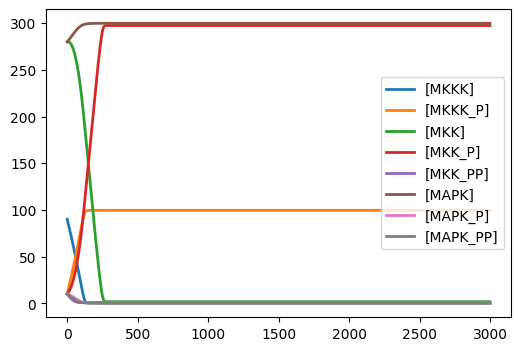

In [2]:
new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
r.model.setGlobalParameterValues(new_parameter_values)

result = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result)

In [52]:
class SBMLGlobalFit:
    global r

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]
        self.r = None
        
    def fitness(self, x):
        # if self.r is None:
        #     self.r = te.loadSBMLModel(self.model)
        #     self.r = te.loadSBMLModel(self.r.getParamPromotedSBML(self.r.getSBML()))

        results = r.simulate(0, 3000, 5000)
        return self._residual(results,self.data,5000)
        # return [0]

    def _residual(self,results,data,points):
        md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
        mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
        denom = np.ones(data.shape)
        return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [9]:
import ipyparallel as ipp
import pygmo as pg
pg.ipyparallel_island()
cluster = ipp.Cluster(n=1)
await cluster.start_cluster()
rc = cluster.connect_client_sync()


Starting 1 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


In [51]:
rc._ids

[0]

In [10]:
dview = rc[:]

In [64]:
def load_model(modelfile):
    import tellurium as te
    global r
    r = te.loadSBMLModel(modelfile)
    r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))
    return 1

In [60]:
dview.apply_sync(load_model, modelfile)

[1]

In [74]:
def test():
    global r
    r.reset()
    return 2

dview.execute('r.asgasdg()', block=True)

CompositeError: one or more exceptions raised in: execute
[0:execute]AttributeError: 'RoadRunner' object has no attribute 'asgasdg'

In [75]:
dview.apply_sync(test)

CompositeError: one or more exceptions raised in: test
[0:apply]NameError: name 'r' is not defined

In [39]:
class my_island(pg.ipyparallel_island):
    def __init__(self, view):
        pg.ipyparallel_island.__init__(self)
        self._view_to_load = view

In [43]:
lbview = rc.load_balanced_view()
udi = pg.ipyparallel_island()
udi._view =  lbview

In [44]:
import pygmo as pg
a_cstrs_sa = pg.algorithm(pg.cmaes(gen = 10, sigma0=0.3))
p_toy = pg.problem(SBMLGlobalFit(model = modelfile, data = result, parameters=parameter_values, settings=None))
archi = pg.archipelago(n=3,algo=a_cstrs_sa, prob=p_toy, pop_size=10, udi = udi)

TypeError: cannot pickle 'Context' object

In [6]:
archi

Number of islands: 3
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: idle

Islands summaries:

	#  Type           Algo                                                        Prob                                  Size  Status  
	----------------------------------------------------------------------------------------------------------------------------------
	0  Thread island  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Multidimensional Rosenbrock Function  10    idle    
	1  Thread island  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Multidimensional Rosenbrock Function  10    idle    
	2  Thread island  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Multidimensional Rosenbrock Function  10    idle    

In [29]:
p_toy.extract(SBMLGlobalFit).model

'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'